In [ ]:
import json
import PySAM.Pvwattsv8 as PV # Adjusted from Pvwattsv8 since I noticed that this was not one of the exported JSON files
import PySAM.Battwatts as Battery

pv = PV.new()

dir = "../SAM_configuration/"

file_names = ["untitled__1__pvwattsv8"]
modules = [pv]

for f, m in zip(file_names, modules):
    with open(dir + f + ".json", 'r') as file:
        data = json.load(file)
        print(file)
        for k, v in data.items():
            print(k)
            print(v)
            if k not in ["number_inputs", "batt_adjust_constant", "batt_adjust_en_timeindex", "batt_adjust_en_periods", "batt_adjust_timeindex", "batt_adjust_periods"]:
                m.value(k, v)

pv.execute(0)

# For Storage
file_names = ["untitled__1__battwatts"]
battery = Battery.from_existing(pv)
# battery.gen = pv.Outputs.gen

for f, m in zip(file_names, [battery]):
    with open(dir + f + ".json", 'r') as file:
        data = json.load(file)
        print(file)
        for k, v in data.items():
            print(k)
            print(v)
            if k not in ["number_inputs", "batt_adjust_constant", "batt_adjust_en_timeindex", "batt_adjust_en_periods", "batt_adjust_timeindex", "batt_adjust_periods"]:
                m.value(k, v)


load_profile = [10] * 8760
battery.Battery.assign({'load': load_profile})

battery.execute(0)

system_to_load = battery.Outputs.system_to_load
batt_to_load = battery.Outputs.batt_to_load
grid_to_load = battery.Outputs.grid_to_load
grid_to_batt = battery.Outputs.grid_to_batt
system_to_batt = battery.Outputs.system_to_batt
system_to_batt_dc = battery.Outputs.system_to_batt_dc
system_to_grid = battery.Outputs.system_to_grid
battery_soc = battery.Outputs.batt_SOC





<_io.TextIOWrapper name='../SAM_configuration/untitled__1__pvwattsv8.json' mode='r' encoding='UTF-8'>
solar_resource_file
/Applications/SAM_2025.4.16/SAM.app/Contents/solar_resource/phoenix_az_33.450495_-111.983688_psmv3_60_tmy.csv
albedo
[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
use_wf_albedo
1
system_use_lifetime_output
0
analysis_period
25
system_capacity
8
module_type
0
dc_ac_ratio
1.15
bifaciality
0
array_type
1
tilt
20
azimuth
180
gcr
0.3
soiling
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
losses
14.075660688264469
en_snowloss
0
inv_eff
96
shading_en_string_option
0
shading_string_option
0
shading_en_timestep
0
shading_timestep
[[0]]
shading_en_mxh
0
shading_mxh
[[0]]
shading_en_azal
0
shading_azal
[[0]]
shading_en_diff
0
shading_diff
0
batt_simple_enable
1
adjust_constant
0
adjust_en_timeindex
0
adjust_en_periods
0
adjust_timeindex
[0]
adjust_periods
[[0, 0, 0]]
<_io.TextIOWrapper name='../SAM_configuration/untitled__1__battwatts.json' mode='r' encoding='UTF-8'>
batt

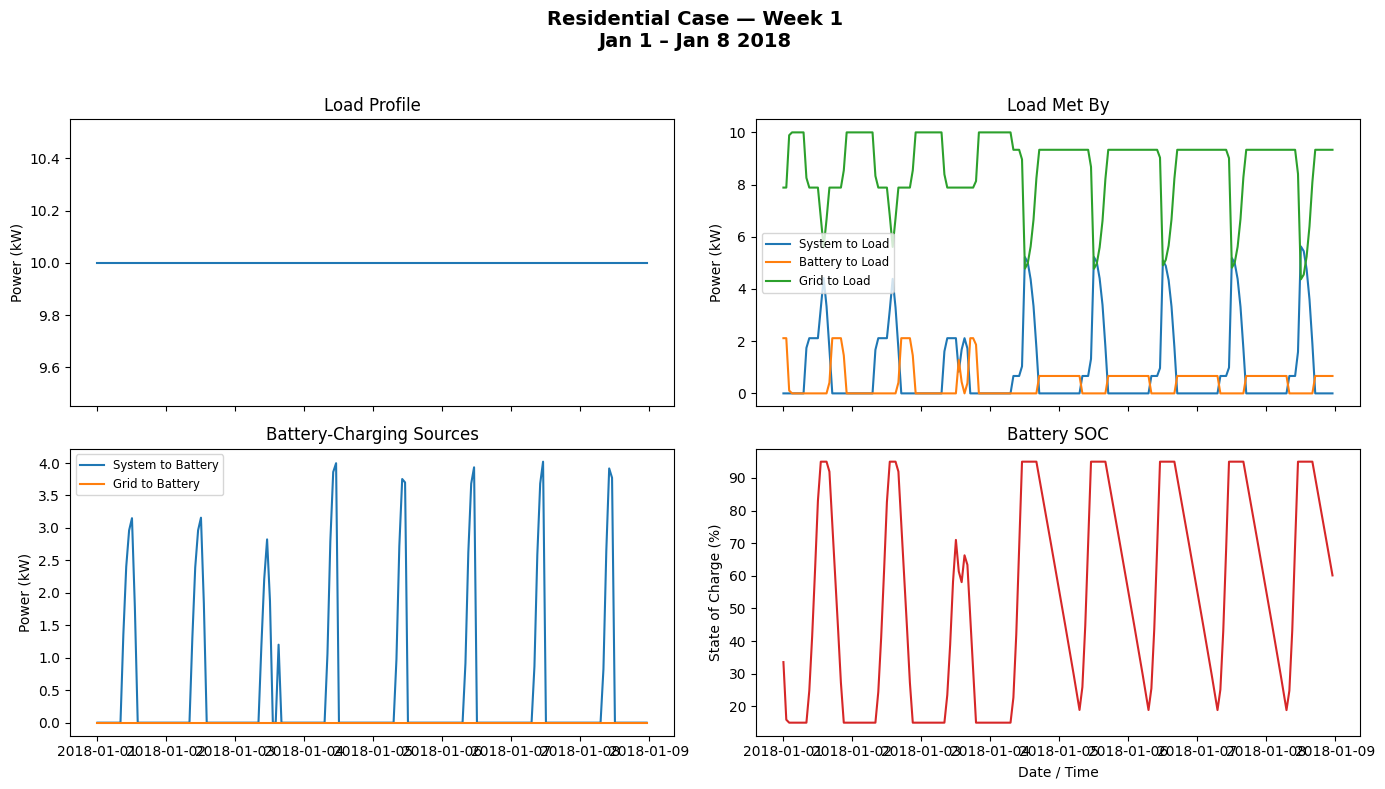

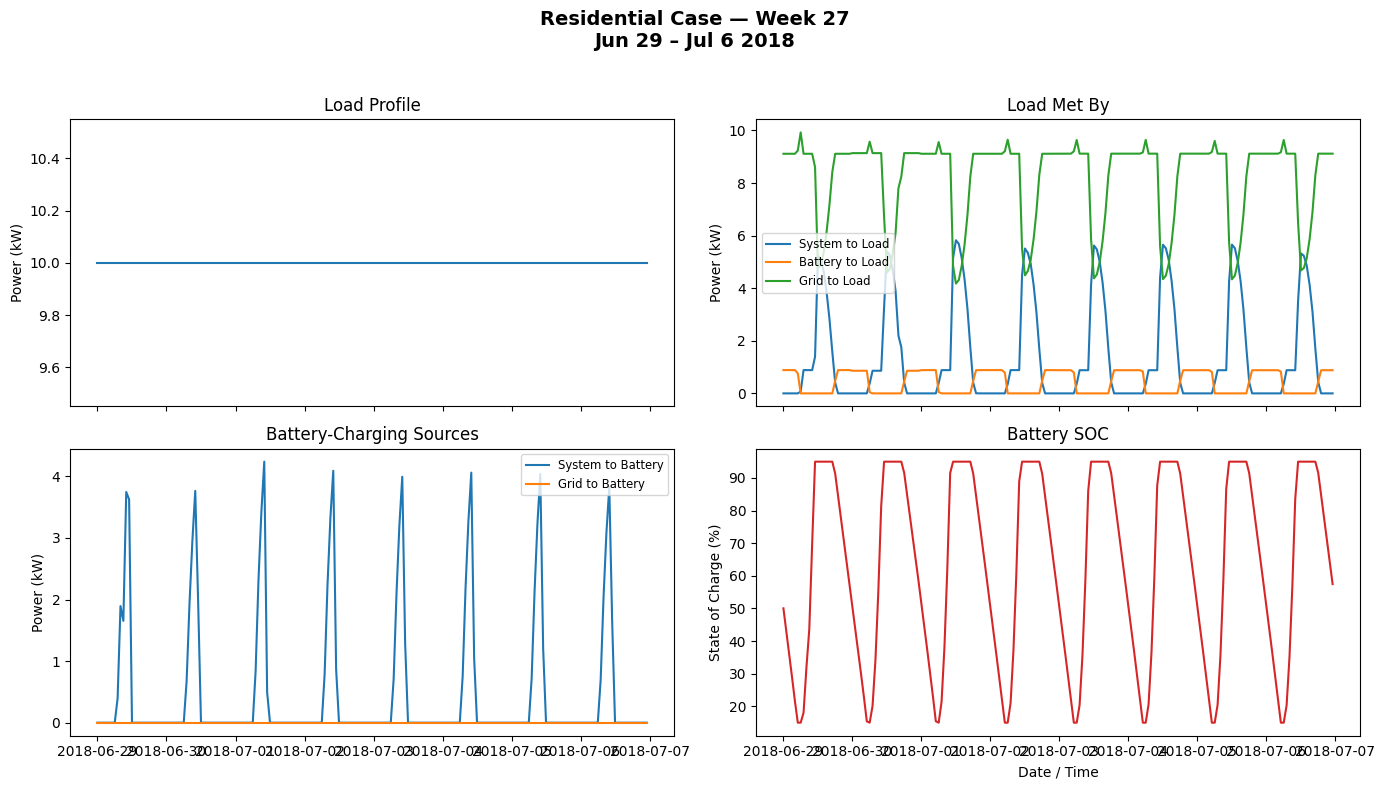

In [36]:
# ---------------------------------------------------------------------
# 1)  Build a tidy DataFrame from BattWatts outputs
# ---------------------------------------------------------------------
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime as dt

n_steps = len(load_profile)          # 8 760 for an hourly run

# Give the index real timestamps so you can slice by date later.
# Start date can be anything; 1 Jan 2018 matches your earlier CSVs.
idx = pd.date_range('2018-01-01', periods=n_steps, freq='H')

df = pd.DataFrame({
    'Load Profile'      : load_profile,
    'System to Load'    : system_to_load,     # AC flow from PV+inverter
    'Battery to Load'   : batt_to_load,       # AC flow from battery
    'Grid to Load'      : grid_to_load,       # AC flow from utility
    'System to Battery' : system_to_batt,     # AC flow into battery   [oai_citation:0‡nrel-pysam.readthedocs.io](https://nrel-pysam.readthedocs.io/en/main/modules/Battwatts.html?utm_source=chatgpt.com)
    'Grid to Battery'   : grid_to_batt,       # AC flow into battery   [oai_citation:1‡nrel-pysam.readthedocs.io](https://nrel-pysam.readthedocs.io/en/v4.2.0/modules/Battwatts.html?utm_source=chatgpt.com)
    'Battery SOC'       : battery_soc         # %
}, index=idx)

# ---------------------------------------------------------------------
# 2)  Define which slices of the year you want to inspect
# ---------------------------------------------------------------------
weeks = [
    ("Week 1\nJan 1 – Jan 8 2018",  "2018-01-01", "2018-01-08 23:00"),
    ("Week 27\nJun 29 – Jul 6 2018", "2018-06-29", "2018-07-06 23:00"),
]

# Column groupings for the four sub-plots
LOAD_COL      = ["Load Profile"]
LOAD_MEET_COL = ["System to Load", "Battery to Load", "Grid to Load"]
BATT_IN_COL   = ["System to Battery", "Grid to Battery"]
SOC_COL       = ["Battery SOC"]

# ---------------------------------------------------------------------
# 3)  Re-use the same plotting helper
# ---------------------------------------------------------------------
def plot_week(df_slice, title):
    fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex=True)
    fig.suptitle(title, fontsize=14, fontweight='bold')

    # A) Load profile
    axes[0, 0].plot(df_slice.index, df_slice[LOAD_COL[0]])
    axes[0, 0].set_title("Load Profile")
    axes[0, 0].set_ylabel("Power (kW)")

    # B) How the load is met
    for col in LOAD_MEET_COL:
        axes[0, 1].plot(df_slice.index, df_slice[col], label=col)
    axes[0, 1].set_title("Load Met By")
    axes[0, 1].set_ylabel("Power (kW)")
    axes[0, 1].legend(fontsize='small')

    # C) What’s charging the battery
    for col in BATT_IN_COL:
        axes[1, 0].plot(df_slice.index, df_slice[col], label=col)
    axes[1, 0].set_title("Battery-Charging Sources")
    axes[1, 0].set_ylabel("Power (kW)")
    axes[1, 0].legend(fontsize='small')

    # D) Battery state-of-charge
    axes[1, 1].plot(df_slice.index, df_slice[SOC_COL[0]], color='tab:red')
    axes[1, 1].set_title("Battery SOC")
    axes[1, 1].set_ylabel("State of Charge (%)")
    axes[1, 1].set_xlabel("Date / Time")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# ---------------------------------------------------------------------
# 4)  Produce one four-panel figure per week
# ---------------------------------------------------------------------
for week_title, start, end in weeks:
    slice_ = df.loc[start:end]
    if slice_.empty:
        print(f"No data for {week_title}")
        continue
    plot_week(slice_, f"Residential Case — {week_title}")